In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation,Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical, normalize

2022-03-12 10:27:24.260783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-12 10:27:24.260816: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Setting up the dir paths for 

In [2]:
ROOT_DIR = r"../data/"

NO_TUMOR_IMAGES = os.listdir(ROOT_DIR + 'no/')
YES_TUMOR_IMAGES = os.listdir(ROOT_DIR + 'yes/')

dataset = []
# 0 : no Tumor   1: Tumor
label = []

INPUT_SIZE = 64
print(len(NO_TUMOR_IMAGES))

1500


## Loading our custom image data to an array

In [3]:
for i , image_name in enumerate(NO_TUMOR_IMAGES):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(ROOT_DIR+'no/'+image_name)
        image=Image.fromarray(image,'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(0)

for i , image_name in enumerate(YES_TUMOR_IMAGES):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(ROOT_DIR+'yes/'+image_name)
        image=Image.fromarray(image, 'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(1)
len(label)

3000

In [4]:
dataset = np.array(dataset)
label = np.array(label)

## Inspecting element of a dataset

In [5]:
label_df = pd.Series(label)
label_df.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

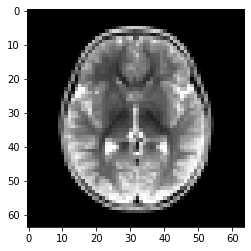

In [6]:
plt.imshow(dataset[1])

## Performing some basic EDA on the Dataset

Counter({0: 1500, 1: 1500})
dict_keys(['Healthy_Images', 'Tummorous_Images'])


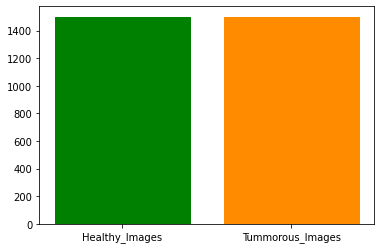

In [7]:
from collections import Counter

c = Counter(label)
print(c)

c['Healthy_Images'] = c[0]
del c[0]
c['Tummorous_Images'] = c[1]
del c[1]
print(c.keys())
#plot each key and value in c 
plot=plt.bar(c.keys(), c.values())
plot[0].set_color('green')
plot[1].set_color('darkorange')

## Splitting the dataset

In [8]:
x_train,x_test,y_train,y_test = train_test_split(dataset,label,test_size=0.2,random_state=0)

In [9]:
x_train = normalize(x_train,axis=1)
x_test = normalize(x_test,axis=1)

# Building the CNN-Model 

In [10]:
model = Sequential()

# 1st layer
model.add(Conv2D(32,(3,3),input_shape = (INPUT_SIZE,INPUT_SIZE,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd Conv Layer
model.add(Conv2D(32,(3,3),kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# 3rd Conv Layer
model.add(Conv2D(32,(3,3),kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# # 4th conv2D layer
model.add(Conv2D(32,(3,3),kernel_initializer='he_uniform'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))


# Flattening Layer for the Fully connected layer
model.add(Flatten())

# Dense Layer
model.add(Dense(INPUT_SIZE))
model.add(Activation('relu'))

# Dropout layer\
model.add(Dropout(0.5))

# Final Output layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 activation (Activation)     (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 29, 29, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                    

2022-03-12 10:27:45.854168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/suman/.pyenv/versions/3.9.5/envs/machineLearningENV/lib/python3.9/site-packages/cv2/../../lib64:
2022-03-12 10:27:45.854217: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-12 10:27:45.854235: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (machine): /proc/driver/nvidia/version does not exist
2022-03-12 10:27:45.854460: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler f

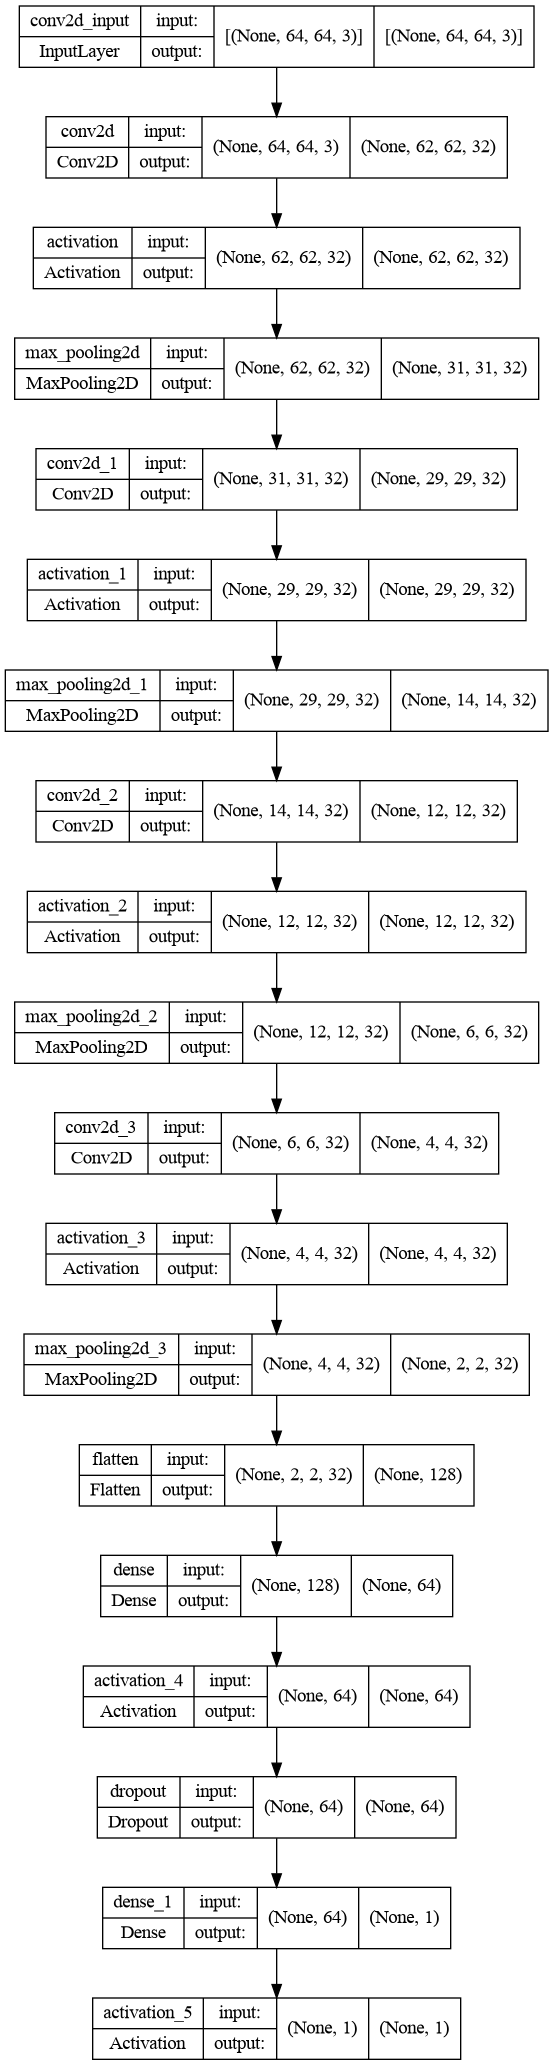

In [11]:
tf.keras.utils.plot_model(
    model,
    to_file='cnn_model.png',
    show_shapes=True,
    expand_nested=True
)

## Function for plotting Training / validation loss

In [12]:
def tr_plot(tr_data, start_epoch):
    #Plot the loss and accuracy curve
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'orange', label='Training loss')
    axes[0].plot(Epochs,vloss,'blue',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'orange',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'blue',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout

#     plt.show()

# Compiling the model

In [13]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
    
)

history = model.fit(
    x_train,
    y_train,
    batch_size=200,
    verbose=1,
    epochs = 50,
    validation_data=(x_test,y_test),
    shuffle=False
    
)



Epoch 1/50
12/12 [==============================] - 4s 278ms/step - loss: 0.6883 - accuracy: 0.5529 - val_loss: 0.6658 - val_accuracy: 0.6433
Epoch 2/50
12/12 [==============================] - 3s 265ms/step - loss: 0.6574 - accuracy: 0.6454 - val_loss: 0.5982 - val_accuracy: 0.7350
Epoch 3/50
12/12 [==============================] - 3s 266ms/step - loss: 0.5823 - accuracy: 0.7175 - val_loss: 0.5109 - val_accuracy: 0.7450
Epoch 4/50
12/12 [==============================] - 3s 265ms/step - loss: 0.5378 - accuracy: 0.7379 - val_loss: 0.4968 - val_accuracy: 0.7533
Epoch 5/50
12/12 [==============================] - 4s 324ms/step - loss: 0.5146 - accuracy: 0.7504 - val_loss: 0.4758 - val_accuracy: 0.7883
Epoch 6/50
12/12 [==============================] - 4s 346ms/step - loss: 0.4801 - accuracy: 0.7842 - val_loss: 0.4477 - val_accuracy: 0.7833
Epoch 7/50
12/12 [==============================] - 4s 337ms/step - loss: 0.4721 - accuracy: 0.7875 - val_loss: 0.4502 - val_accuracy: 0.7767
Epoch 

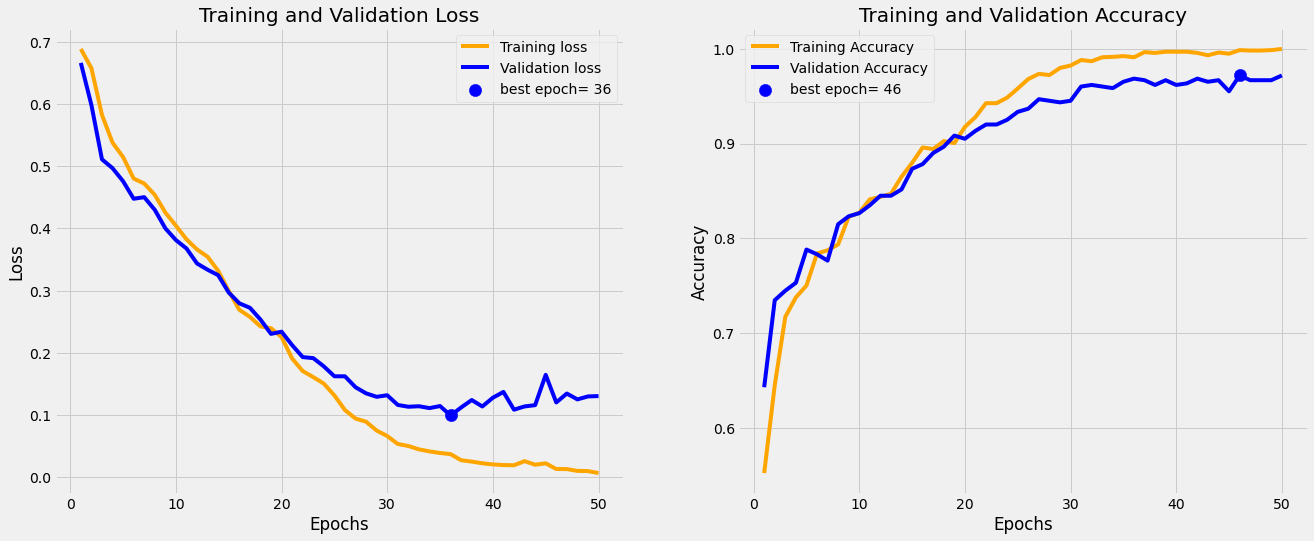

In [17]:
tr_plot(history,0)
plt.savefig('history_batch_200_epochs_50_accuracy_9710.png')
plt.show()
# model.save('BrainTumor_proto_3.h5')
